In [ ]:
# default_exp funcs.file_io

In [ ]:
%load_ext autoreload
%autoreload 2

# File handling

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.utils import *
from tifffile import imread
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.psf import crop_psf
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.dataset import *
from torch.utils.data import DataLoader

In [ ]:
#export
def load_model_state(model, path):
    """
    Loads the network parameters, the intensity parameters and the scaling into model given a path.
    """
    model_dict = torch.load(path)
    model.load_state_dict(model_dict['state_dict'])
    model.inp_scale = model_dict['scaling'][0]
    model.inp_offset = model_dict['scaling'][1]
    return model

In [ ]:
#export
def simfish_to_df(sim_file, frame_idx=0):
    
    yxzi = []
    with open(sim_file) as f:
        read = False
        for line in f:
            if 'Pos_Y' in line: 
                read = True
                continue
            if 'SPOTS_END' in line: break
            if read: yxzi.append([float(s) for s in line.split()])

    yxzi = np.array(yxzi)#/px_size
    loc_idx = np.arange(len(yxzi))
    # Number calculated by taking into account their (or my?) normalization (by max and not by sum)
    if yxzi.shape[1] == 4:
        # PSF.max() | PSF.sum() | 3**3 (superres)  | PSF.max() | microscope scale
        # ints = yxzi[:,3] * 65535.0 * 156772560.0 / 27 / 65535.0 / 10000.0
        ints = yxzi[:,3] * 65535.0 / 100.0 / 1.23
    else:
        ints = np.ones_like(loc_idx)
    
    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': frame_idx,
                       'x': yxzi[:,1],
                       'y': yxzi[:,0], 
                       'z': yxzi[:,2], 
                       'prob': np.ones_like(loc_idx), 
                       'int': ints, 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})

    return df   

#export 
def load_sim_fish(basedir, mrna_lvl=200, shape='cell3D', exp_strength='strong', cell_nr=0, shift=[-38,-38,-110]):
    
    spec_dir = f'/mRNAlevel_{mrna_lvl}/{shape}/{exp_strength}/'
    img_path = sorted(glob.glob(basedir + spec_dir + 'w1*.tif'))[cell_nr]
    cellname = Path(img_path).name.split('.')[0]
#     print(name)
    img = load_tiff_image(img_path)
    gt_df = simfish_to_df(img_path.split('.')[0] + '.txt')
    fq_nog_df = fq_gmm_df = DF()
    if os.path.exists(basedir + '/_results_detection/'):
        nog_path = Path(basedir + '/_results_detection/' + spec_dir + '/results_noGMM/' + cellname + '_res_NO_GMM.txt')
        gmm_path = Path(basedir + '/_results_detection/' + spec_dir + '/results_GMM/' + cellname + '_res_GMM.txt')

        if nog_path.is_file(): 
            fq_nog_df = simfish_to_df(nog_path)
            fq_nog_df = shift_df(fq_nog_df, shift)
        if gmm_path.is_file(): 
            fq_gmm_df = simfish_to_df(gmm_path)
            fq_gmm_df = shift_df(fq_gmm_df, shift)
        
    return img, gt_df, fq_nog_df, fq_gmm_df

#export
def big_fishq_to_df(file_str):
    
    csv = pd.read_csv(file_str,sep=';',names=['z','y','x'], index_col=False)

    zyx = np.array(csv)
    loc_idx = np.arange(len(zyx))

    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': np.zeros_like(loc_idx),
                       'x': zyx[:,2],
                       'y': zyx[:,1], 
                       'z': zyx[:,0], 
                       'prob': np.ones_like(loc_idx), 
                       'int': np.ones_like(loc_idx), 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})
    
    return df

def rsfish_to_df(file_str):
    
    csv = pd.read_csv(file_str,sep='  ',names=['x','y','z','?','??'], index_col=False)
    
    xyz = np.array(csv)
    loc_idx = np.arange(len(xyz))

    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': np.zeros_like(loc_idx),
                       'x': xyz[:,1],
                       'y': xyz[:,0], 
                       'z': xyz[:,2], 
                       'prob': np.ones_like(loc_idx), 
                       'int': np.ones_like(loc_idx), 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})
    
    return df

In [ ]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/'
img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 250, 'random', 'NR', 2)

(array([29., 51., 69., 62., 41., 18.,  9., 11.,  0.,  1.]),
 array([ 2.90544835,  3.75645113,  4.6074539 ,  5.45845668,  6.30945946,
         7.16046223,  8.01146501,  8.86246779,  9.71347056, 10.56447334,
        11.41547612]),
 <BarContainer object of 10 artists>)

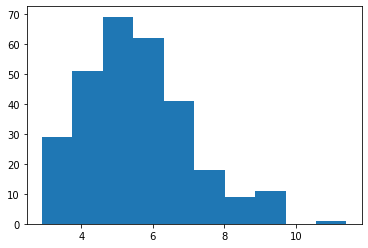

In [ ]:
plt.hist(gt_df['int'])

In [ ]:
# load_big_fishq('deepstorm/datasets/CodFish/smFISH_data_Titlow/detections/sgg_smFISH_4_spots.csv')
f_name = '../../../deepstorm/datasets/CodFish/smFISH_data_Titlow/detections/sgg_smFISH_4_spots.csv'
tiff = load_tiff_image(Path(f_name).parent.parent/'sgg_smFISH_4.tif')
print(tiff.shape)

df = big_fishq_to_df(f_name)

torch.Size([1, 25, 512, 512])


(0.0, 200.0)

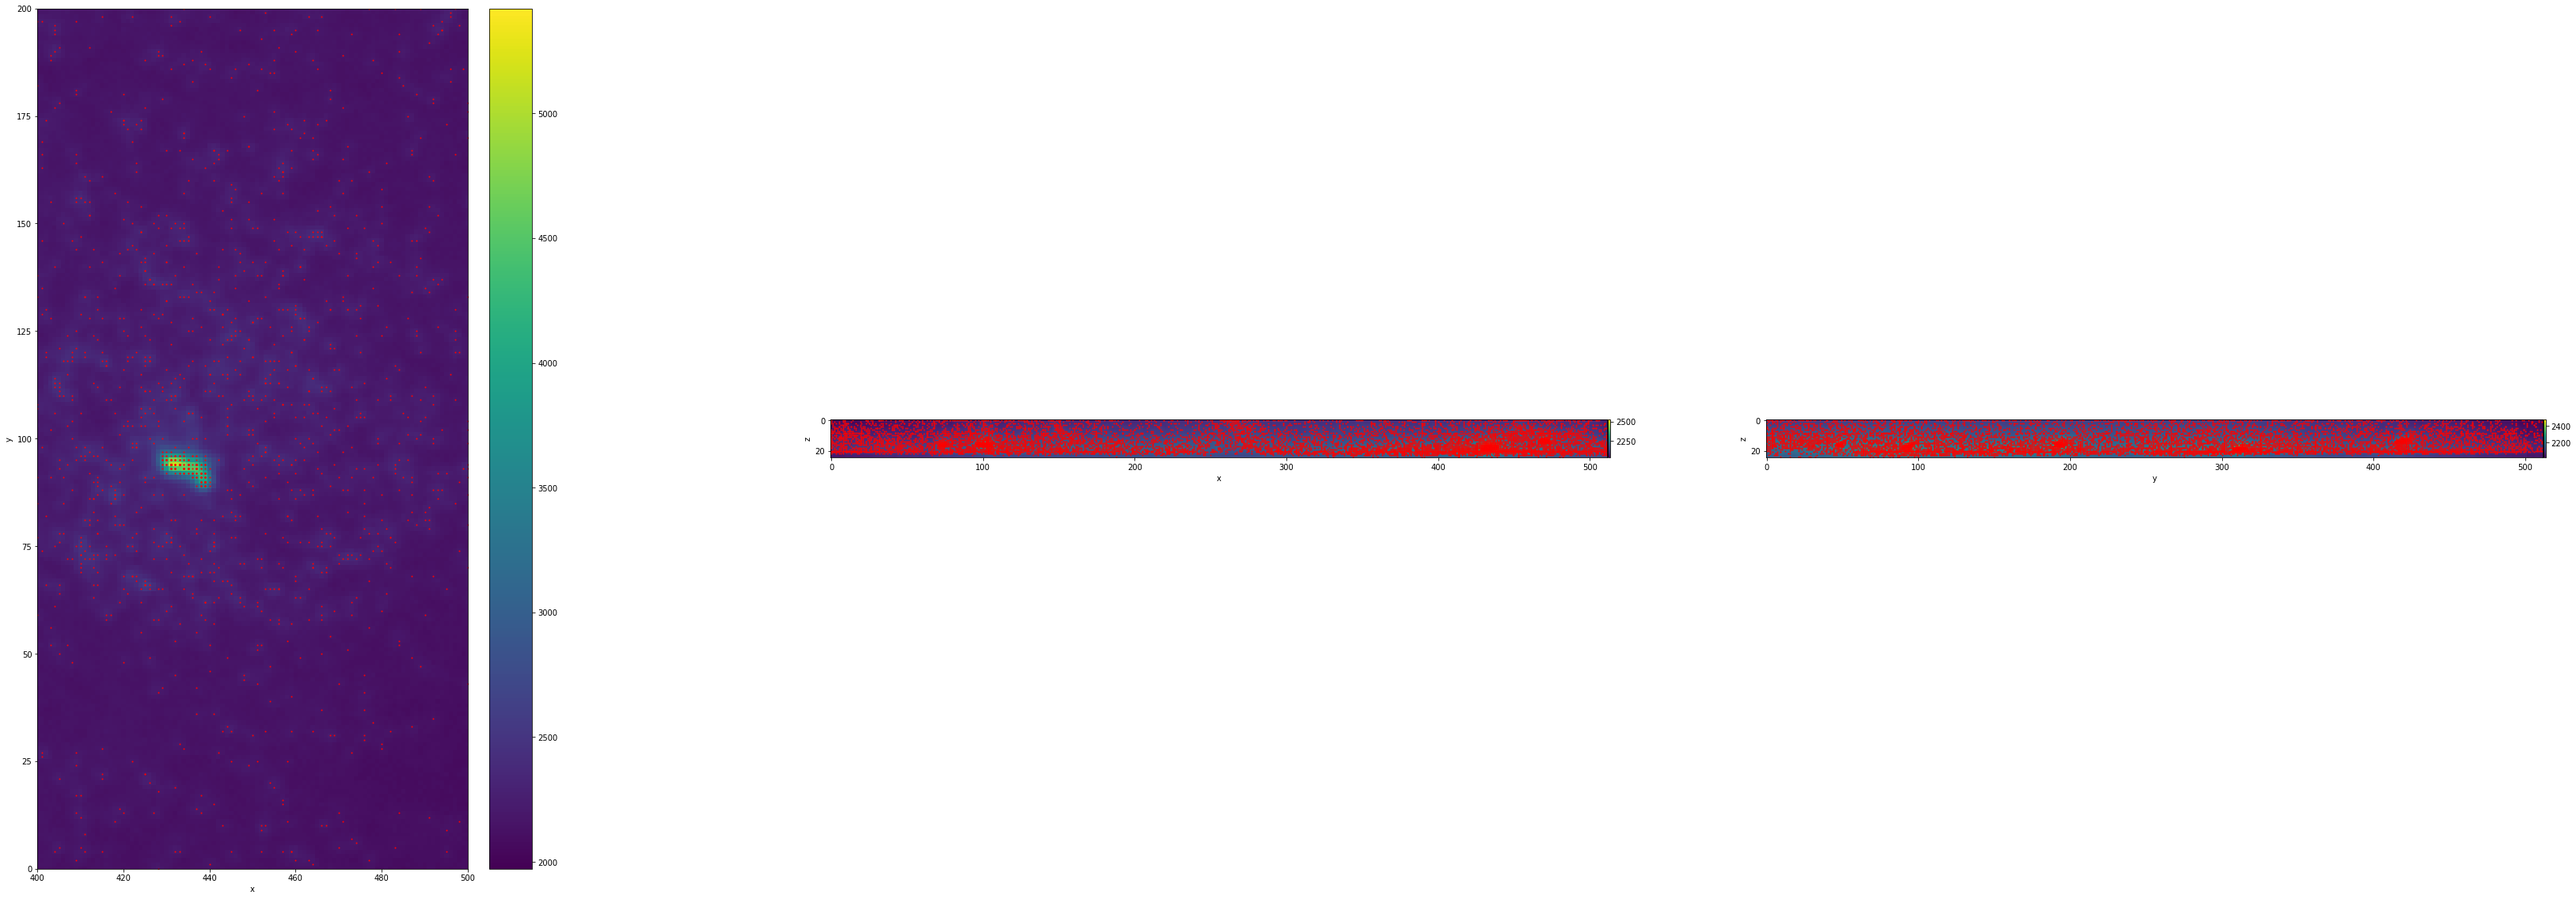

In [ ]:
from decode_fish.funcs.plotting import *
from decode_fish.funcs.emitter_io import *

axes = plot_3d_projections(tiff[0], size=20)
axes[0].scatter(df['x'],df['y'], color='red', s=1)
axes[1].scatter(df['x'],df['z'], color='red', s=1)
axes[2].scatter(df['y'],df['z'], color='red', s=1)
axes[0].set_xlim(400,500)
axes[0].set_ylim(0,200)

In [ ]:
#export
def swap_psf_vol(psf, vol):
    state_dict = psf.state_dict()
    state_dict['psf_volume'][0] = torch.cuda.FloatTensor(torch.Tensor(vol).cuda())
    psf.load_state_dict(state_dict)
    return psf

def get_gaussian_psf(size_zyx, radii):
    psf = LinearInterpolatedPSF(size_zyx, device='cuda')
    gauss_vol = gaussian_sphere(size_zyx, radii, [size_zyx[0]//2,size_zyx[1]//2,size_zyx[2]//2])
    gauss_vol = gauss_vol/gauss_vol.max()
#     gauss_vol = np.log(gauss_vol+1e-6)
    psf = swap_psf_vol(psf, gauss_vol)
    return psf

def load_psf(cfg):

    if cfg.data_path.psf_path:
        if 'tif' in cfg.data_path.psf_path:
            psf_vol = load_tiff_image(cfg.data_path.psf_path)
#             psf_vol = torch.log(psf_vol)
            psf = LinearInterpolatedPSF(psf_vol.shape[-3:], cfg.PSF.device)
            psf = swap_psf_vol(psf, psf_vol)
            
        else:
            psf_state = torch.load(cfg.data_path.psf_path)
            psf = LinearInterpolatedPSF(psf_state['psf_volume'].shape[-3:], cfg.PSF.device)
            psf.load_state_dict(psf_state)

            if cfg.PSF.psf_extent_zyx:
                psf = crop_psf(psf,cfg.PSF.psf_extent_zyx)
                
    else:
        
        psf = get_gaussian_psf(cfg.PSF.psf_extent_zyx, cfg.PSF.gauss_radii)
        
    return psf

def load_psf_noise_micro(cfg):
    
    psf = load_psf(cfg)
    noise = hydra.utils.instantiate(cfg.noise)
    micro = hydra.utils.instantiate(cfg.microscope, psf=psf, noise=noise).cuda()
    
    return psf, noise, micro

def load_post_proc(cfg):
    if cfg.other.pp == 'si':
        return hydra.utils.instantiate(cfg.post_proc_si)
    if cfg.other.pp == 'isi':
        return hydra.utils.instantiate(cfg.post_proc_isi)
    
def get_dataloader(cfg):

    imgs_3d        = [load_tiff_image(f)[0] for f in sorted(glob.glob(cfg.data_path.image_path))]
    estimate_backg = hydra.utils.instantiate(cfg.bg_estimation)
    roi_masks     = [get_roi_mask(img, tuple(cfg.roi_mask.pool_size), percentile= cfg.roi_mask.percentile) for img in imgs_3d]
    
    min_shape = tuple(np.stack([v.shape for v in imgs_3d]).min(0)[-3:])
    crop_zyx = (cfg.random_crop.crop_sz, cfg.random_crop.crop_sz,cfg.random_crop.crop_sz)
    if crop_zyx > min_shape:
        crop_zyx = tuple(np.stack([min_shape, crop_zyx]).min(0))
        print('Crop size larger than volume in at least one dimension. Crop size changed to', crop_zyx)
    
    rand_crop = RandomCrop3D(crop_zyx, roi_masks)
    
#     probmap_generator = ScaleTensor(low=cfg.prob_generator.low, 
#                                     high=cfg.prob_generator.high)
#     rand_scale = RandScale(0.1,1.)
#     rate_tfms = [estimate_backg, probmap_generator, rand_scale]
    
    probmap_generator = UniformValue(cfg.prob_generator.low, cfg.prob_generator.high)
    rate_tfms = [probmap_generator]
    
    dataset_tfms = [rand_crop]
    
    if cfg.foci is not None:
        if cfg.foci.n_foci_avg > 0:
            rate_tfms.append(hydra.utils.instantiate(cfg.foci))

    ds = DecodeDataset(path = cfg.data_path.image_path,
                       dataset_tfms =  dataset_tfms, 
                       rate_tfms = rate_tfms, 
                       bg_transform = estimate_backg, 
                       device='cuda:0', 
                       num_iter=(cfg.training.num_iters) * cfg.training.bs) 

    decode_dl = DataLoader(ds, batch_size=cfg.training.bs, num_workers=0)
    
    return imgs_3d, decode_dl
    
def load_all(cfg):
    
    path = Path(cfg.output.save_dir)
    model = hydra.utils.instantiate(cfg.model)
    model = load_model_state(model, path/'model.pkl')
    post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold=0.5)
    psf, noise, micro = load_psf_noise_micro(cfg)
    psf.load_state_dict(torch.load(path/'psf.pkl'))
    psf.cuda()
    img_3d, decode_dl = get_dataloader(cfg)
    
    return model, post_proc, psf, micro, img_3d, decode_dl

In [ ]:
cfg = OmegaConf.load('../config/experiment/msp300_smFISH_3_6.yaml')
cfg = OmegaConf.load(default_conf)
psf = load_psf(cfg)
# psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))

In [ ]:
torch.clamp_min(psf.psf_volume[0],0).sum()

tensor(15.7496, grad_fn=<SumBackward0>)

In [ ]:
psf.psf_volume[0].max()

tensor(1., grad_fn=<MaxBackward1>)

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

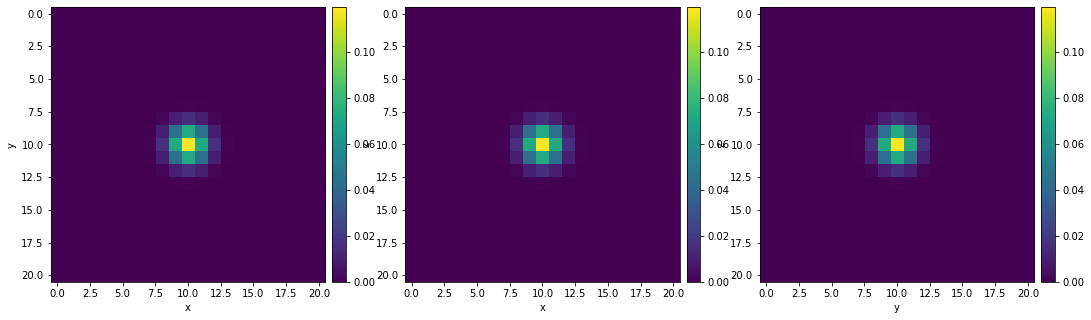

In [ ]:
from decode_fish.funcs.plotting import *
plot_3d_projections(psf.psf_volume[0])

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted index.ipynb.
